In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
# %matplotlib inline
%config Completer.use_jedi = False

In [2]:
from datasets import InsectImgDataset
from utils import *
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import albumentations as A

from torchvision import datasets, transforms
import torch.optim as optim
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.utils import class_weight

setting = 'fuji'
if setting == 'photobox':
    ext = '.png'
elif setting == 'fuji':
    ext = '.jpg'

Available workers: 16


In [3]:
dfs = InsectImgDataset(ext=ext, setting=setting, directory=DATA_DIR)
dfs.extract_df_info()
df = dfs.df

Extracting info from filenames..: 100%|██████████| 67841/67841 [00:09<00:00, 7298.95it/s]


# Creating train,val,test sets

In [4]:
df_pre = pd.read_parquet(f"{SAVE_DIR}/df_preparation_{setting}.parquet")
df = pd.merge(df,df_pre, on=['filename','label','platename','imgname','date','year','plate_idx','location','xtra'])
df = df[df.knn_outlier==0]
df = df[df.nb_contours>0]
df = df[~df['label'].isin(['st','vuil'])]
df.label = df.label.apply(lambda x: 'v' if x=='v(cy)' else x)

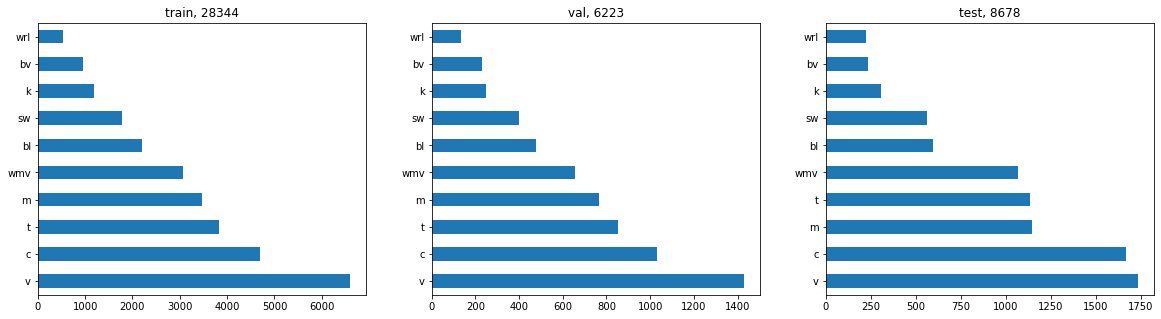

In [6]:
test_plates = train_test_split(df.platename.unique(), random_state=2022, test_size=0.2, shuffle=True)[1].tolist()
testseries = pd.Series(test_plates)
inds = testseries.apply(lambda x: 'wortel' in x)
inds = testseries[inds].sample(10).index.values
wortel_plates = testseries[inds].tolist()
test_plates = testseries[testseries.apply(lambda x: x.split('_')[1] != 'wortel')].tolist() + wortel_plates

df_trainval = df[~df.platename.isin(test_plates)]
df_test = df[df.platename.isin(test_plates)]

topclasses = df['label'].value_counts().head(10).index.tolist()

df = df[df['label'].isin(topclasses)]
df_trainval = df_trainval[df_trainval['label'].isin(topclasses)]
df_test = df_test[df_test['label'].isin(topclasses)]

class_weights = class_weight.compute_class_weight('balanced', 
                                                  classes=np.unique(df['label'].tolist()), 
                                                  y=df['label'].tolist())

class_weights = {np.unique(df['label'])[i]:class_weights[i] for i in range(len(class_weights))}
df['weights'] = df['label'].map(class_weights)

df_train, df_val = train_test_split(df_trainval, test_size=0.18, random_state=42, shuffle=True)

le = LabelEncoder()
le.fit(df_train.label)

plt.figure(figsize=(20,5))
plt.subplot(1,3,1);df_train.label.value_counts().plot(kind='barh');plt.title(f'train, {df_train.shape[0]}')
plt.subplot(1,3,2);df_val.label.value_counts().plot(kind='barh');plt.title(f'val, {df_val.shape[0]}')
plt.subplot(1,3,3);df_test.label.value_counts().plot(kind='barh');plt.title(f'test, {df_test.shape[0]}');

In [7]:
assert len(set(df_train.filename.tolist()).intersection(df_test.filename.tolist())) == 0
assert len(set(df_train.filename.tolist()).intersection(df_val.filename.tolist())) == 0

# Creating Pytorch Datasets and Dataloaders

In [8]:
transforms_list_train = [
#     A.SmallestMaxSize(max_size=150),
#     A.Resize(height=150,width=150,p=1),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225], p=1, always_apply=True),
    A.ShiftScaleRotate(shift_limit=0.01,rotate_limit=45, scale_limit=0, p=.5),
    A.Rotate(limit=90, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
#     A.RandomGamma(p=0.5),
#     A.RandomBrightnessContrast(p=0.2),
#     A.GaussianBlur(blur_limit=(3,3), p=0.1)
]

transforms_list_test = [
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225], 
                p=1, 
                always_apply=True)
]

train_dataset = InsectImgDataset(df=df_train.reset_index(drop=True), transform=A.Compose(transforms_list_train))
valid_dataset = InsectImgDataset(df=df_val.reset_index(drop=True), transform=A.Compose(transforms_list_test))
test_dataset = InsectImgDataset(df=df_test.reset_index(drop=True), transform=A.Compose(transforms_list_test))

batch_size = 32
batch_size_val = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

# plt.imshow(train_dataset[0][0]); plt.title(f"Example train image, class:{train_dataset[0][1]}");

# Defining the model and training parameters

In [9]:
torch.backends.cudnn.benchmark = True

In [10]:
modelname = "densenet121"
model = model_selector(modelname, pretrained=True)
try:
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs,len(topclasses))
except:
    pass
try:
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs,len(topclasses))
except:
    pass
# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
model = model.to('cuda', dtype=torch.float)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=.001)

Train on gpu: True


In [11]:
model, optimizer = load_checkpoint(f'{SAVE_DIR}/{modelname}_{setting}_best.pth.tar', model, optimizer)
model = model.to('cuda', dtype=torch.float)

In [12]:
import seaborn as sns
sns.set(font_scale=1.6)

Testing..	: 100%|██████████| 886/886 [00:32<00:00, 27.12it/s]


Accuracy: 87.87
Balanced accuracy: 90.63
Confusion matrix: 
[[9.41871026e-01 1.13533152e-02 4.99545867e-03 3.63306085e-03
  1.31698456e-02 2.27066303e-03 2.72479564e-03 1.86194369e-02
  1.36239782e-03 0.00000000e+00]
 [0.00000000e+00 9.65660770e-01 2.08116545e-03 1.04058273e-03
  3.12174818e-03 3.12174818e-03 6.24349636e-03 1.76899063e-02
  1.04058273e-03 0.00000000e+00]
 [1.27741111e-03 4.47093890e-03 9.59335746e-01 2.76772408e-03
  7.66446668e-03 3.40642964e-03 1.38386204e-02 6.81285927e-03
  4.25803704e-04 0.00000000e+00]
 [7.63358779e-03 4.24088210e-03 5.93723494e-03 9.10093299e-01
  5.93723494e-03 2.12044105e-02 2.03562341e-02 2.45971162e-02
  0.00000000e+00 0.00000000e+00]
 [6.90647482e-03 4.66187050e-02 8.34532374e-03 2.58992806e-03
  8.56402878e-01 1.89928058e-02 1.41007194e-02 4.20143885e-02
  4.02877698e-03 0.00000000e+00]
 [3.36700337e-03 3.70370370e-02 3.92817059e-03 1.12233446e-02
  2.30078563e-02 8.14814815e-01 4.88215488e-02 5.49943883e-02
  2.80583614e-03 0.00000000e+00

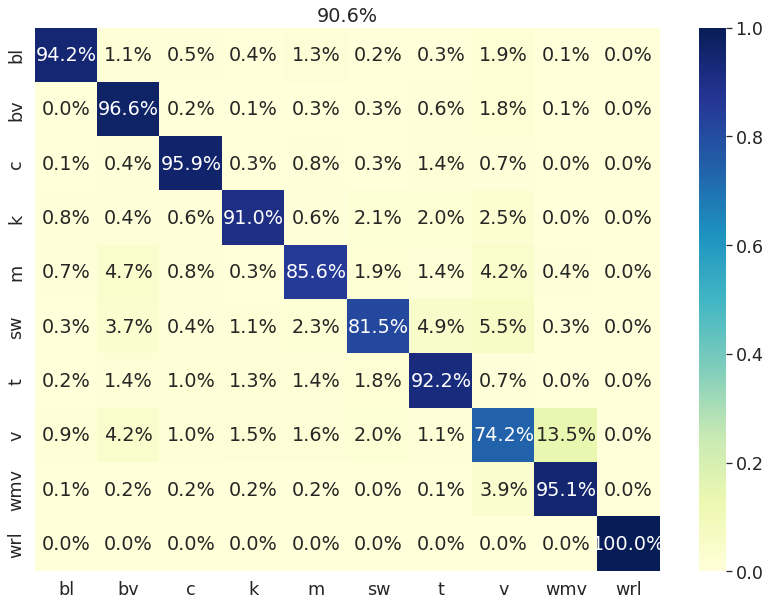

In [13]:
train_bacc, train_cm, _, _, _ = test_model(model,train_dataloader, train_dataset, le)
plt.figure(figsize=(14,10))
sns.heatmap(train_cm, annot=True, fmt='.1%', cmap='YlGnBu', xticklabels=le.classes_, yticklabels=le.classes_); plt.title(f"{train_bacc*100:.1f}%");

Testing..	: 100%|██████████| 195/195 [00:08<00:00, 23.99it/s]


Accuracy: 84.17
Balanced accuracy: 85.73
Confusion matrix: 
[[0.89121339 0.0167364  0.00627615 0.01046025 0.0251046  0.0083682
  0.01046025 0.03138075 0.         0.        ]
 [0.00438596 0.80701754 0.00438596 0.00877193 0.02192982 0.01315789
  0.02192982 0.10964912 0.00877193 0.        ]
 [0.00485437 0.00679612 0.94854369 0.00485437 0.00970874 0.00485437
  0.01165049 0.00679612 0.00194175 0.        ]
 [0.00809717 0.01619433 0.01619433 0.88259109 0.         0.02024291
  0.01214575 0.04453441 0.         0.        ]
 [0.01305483 0.04830287 0.0156658  0.00130548 0.80417755 0.02610966
  0.02480418 0.06396867 0.00261097 0.        ]
 [0.015      0.05       0.0025     0.0175     0.04       0.6825
  0.0825     0.0925     0.0175     0.        ]
 [0.00234742 0.02112676 0.00821596 0.01056338 0.00938967 0.01643192
  0.91314554 0.01525822 0.00352113 0.        ]
 [0.00628931 0.04332635 0.00978337 0.0174703  0.02166317 0.02096436
  0.01048218 0.71348707 0.15653389 0.        ]
 [0.00152439 0.00457317 0

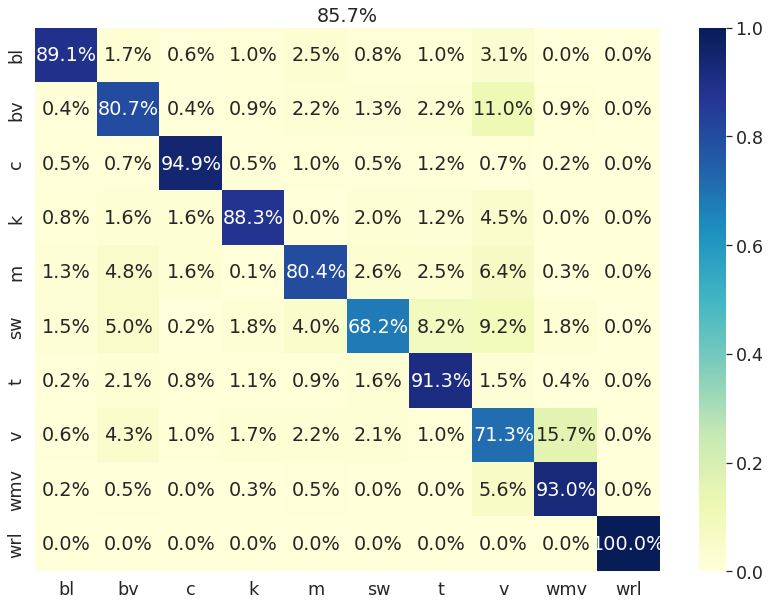

In [14]:
val_bacc, val_cm, _, _, _ = test_model(model,valid_dataloader, valid_dataset, le)
plt.figure(figsize=(14,10))
sns.heatmap(val_cm, annot=True, fmt='.1%', cmap='YlGnBu', xticklabels=le.classes_, yticklabels=le.classes_); plt.title(f"{val_bacc*100:.1f}%");

Testing..	: 100%|██████████| 272/272 [00:10<00:00, 25.62it/s]


Accuracy: 83.37
Balanced accuracy: 82.74
Confusion matrix: 
[[8.28282828e-01 1.34680135e-02 1.68350168e-02 1.01010101e-02
  5.05050505e-02 1.17845118e-02 1.17845118e-02 3.36700337e-02
  2.35690236e-02 0.00000000e+00]
 [4.21940928e-02 6.45569620e-01 1.26582278e-02 2.10970464e-02
  5.06329114e-02 2.95358650e-02 3.37552743e-02 1.39240506e-01
  2.53164557e-02 0.00000000e+00]
 [4.80192077e-03 6.00240096e-04 9.57983193e-01 4.80192077e-03
  5.40216086e-03 2.40096038e-03 1.38055222e-02 8.40336134e-03
  1.80072029e-03 0.00000000e+00]
 [1.96078431e-02 3.26797386e-03 3.26797386e-02 8.30065359e-01
  6.53594771e-03 4.24836601e-02 2.28758170e-02 3.59477124e-02
  6.53594771e-03 0.00000000e+00]
 [1.56931125e-02 5.57977332e-02 8.71839582e-03 6.10287707e-03
  7.91630340e-01 2.44115083e-02 2.35396687e-02 6.27724499e-02
  1.13339146e-02 0.00000000e+00]
 [1.06382979e-02 4.25531915e-02 1.06382979e-02 1.59574468e-02
  4.07801418e-02 7.10992908e-01 7.97872340e-02 7.26950355e-02
  1.59574468e-02 0.00000000e+00

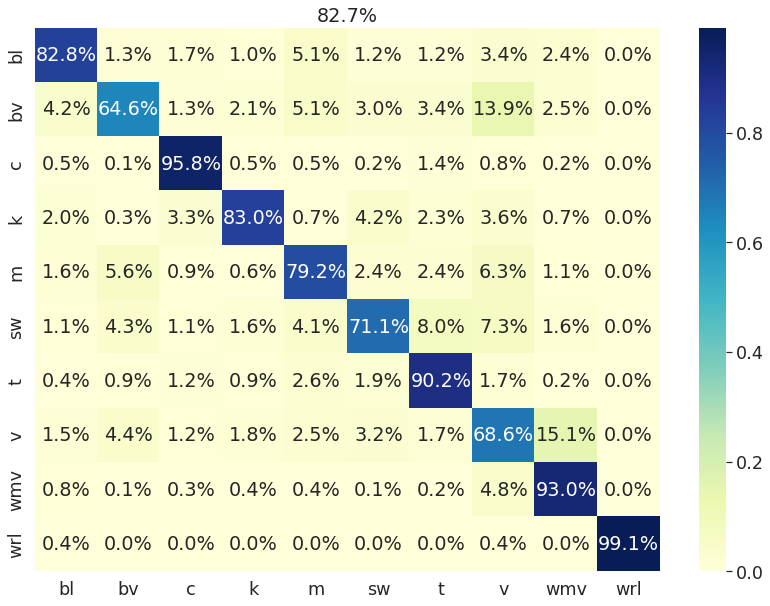

In [15]:
test_bacc, test_cm, y_true, y_pred, info = test_model(model,test_dataloader, test_dataset, le)
plt.figure(figsize=(14,10))
sns.heatmap(test_cm, annot=True, fmt='.1%', cmap='YlGnBu', xticklabels=le.classes_, yticklabels=le.classes_); plt.title(f"{test_bacc*100:.1f}%");

In [16]:
df_res = pd.DataFrame(info)
df_res['pred'] = y_pred
df_res['true'] = y_true
df_res['correct'] = df_res.pred==df_res.true

In [17]:
df_pre = pd.read_parquet(f'{SAVE_DIR}/df_preparation_{setting}.parquet')

In [18]:
cols_to_merge = ['imgname','platename','filename','plate_idx','location','date','xtra']
df_merged = pd.merge(df_res, df_pre, left_on=cols_to_merge, right_on=cols_to_merge)
df_merged['actual_class'] = le.inverse_transform(df_merged.true)
df_merged['pred_class'] = le.inverse_transform(df_merged.pred)

In [19]:
df_merged

,imgname,platename,filename,plate_idx,location,date,year_x,xtra,width,height,...,mean_cnt_perimeter,std_cnt_area,std_cnt_perimeter,R,G,B,knn_outlier,knn_outlier_score,actual_class,pred_class
0,2019_her_2128619_16_48_160_1-15 s_11_48 mm_Man...,her_2128619_16_48_160_1-15 s_11_48 mm_Manual_M...,/home/kalfasyan/data/images/sticky_plates/phot...,121,herent,w26,2019,16,tensor(150),tensor(3),...,30.056349,114.356351,38.735704,196.814311,189.997467,141.782311,0,0.172098,t,t
1,2019_beauv_8719_B_83_160_1-15 s_11_48 mm_Manua...,beauv_8719_B_83_160_1-15 s_11_48 mm_Manual_Man...,/home/kalfasyan/data/images/sticky_plates/phot...,28,beauvechain,w27,2019,B,tensor(150),tensor(3),...,30.835029,121.311263,38.478250,180.839156,173.249111,127.317556,0,0.223851,t,v
2,2019_her_2856719_07_07_160_1-15 s_11_48 mm_Man...,her_2856719_07_07_160_1-15 s_11_48 mm_Manual_M...,/home/kalfasyan/data/images/sticky_plates/phot...,131,herent,w27,2019,07,tensor(150),tensor(3),...,141.982755,0.000000,0.000000,191.163289,184.326889,138.278356,0,0.115435,t,t
3,2020_herent_w33_4-30_F10_51 mm_ISO160_1-15 s_I...,herent_w33_4-30_F10_51 mm_ISO160_1-15 s_Incand...,/home/kalfasyan/data/images/sticky_plates/phot...,40,herent,w33,2020,4-30,tensor(150),tensor(3),...,45.066140,168.935714,35.989531,180.098756,173.362978,117.034356,0,0.089167,t,t
4,2020_herent_w35_2-90_F10_51 mm_ISO160_1-15 s_I...,herent_w35_2-90_F10_51 mm_ISO160_1-15 s_Incand...,/home/kalfasyan/data/images/sticky_plates/phot...,51,herent,w35,2020,2-90,tensor(150),tensor(3),...,30.004434,175.745331,47.760691,172.625956,163.583778,110.304044,0,0.156129,t,t
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8673,2020_Herent_w29_2-90_F10_51 mm_ISO160_1-15 s_I...,Herent_w29_2-90_F10_51 mm_ISO160_1-15 s_Incand...,/home/kalfasyan/data/images/sticky_plates/phot...,339,herent,w29,2020,2-90,tensor(150),tensor(3),...,29.688269,340.411859,66.579686,186.713778,180.034533,130.047644,0,0.272921,sw,v
8674,2019_brainelal_w27_A_80_160_1-15 s_11_48 mm_Ma...,brainelal_w27_A_80_160_1-15 s_11_48 mm_Manual_...,/home/kalfasyan/data/images/sticky_plates/phot...,54,brainelalleud,w27,2019,A,tensor(150),tensor(3),...,31.379572,151.720948,41.194846,193.226178,184.572889,135.738578,0,0.142555,sw,sw
8675,2019_beauv_15_7_B_53_160_1-15 s_11_48 mm_Manua...,beauv_15_7_B_53_160_1-15 s_11_48 mm_Manual_Man...,/home/kalfasyan/data/images/sticky_plates/phot...,378,beauvechain,w28,2019,7,tensor(150),tensor(3),...,21.761793,98.252079,29.053227,190.576133,184.309778,139.737511,0,0.223206,sw,sw
8676,2020_Herent_w28_2-60_F10_51 mm_ISO160_1-15 s_I...,Herent_w28_2-60_F10_51 mm_ISO160_1-15 s_Incand...,/home/kalfasyan/data/images/sticky_plates/phot...,72,herent,w28,2020,2-60,tensor(150),tensor(3),...,21.549411,81.085560,21.873927,207.410089,202.848044,144.405778,0,0.190706,sw,sw


<AxesSubplot:>

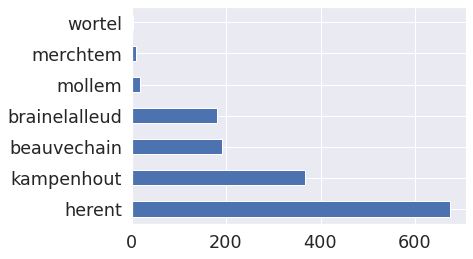

In [20]:
df_merged.query('correct==False').location.value_counts().plot(kind='barh')

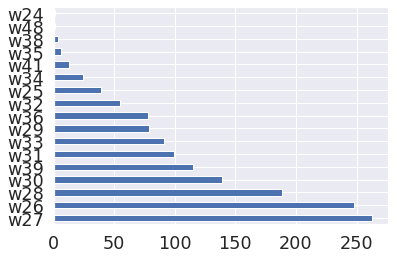

In [21]:
df_merged.query('correct==False').date.value_counts().plot(kind='barh');

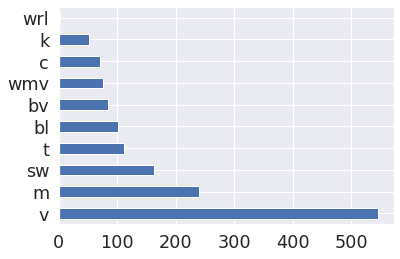

In [22]:
df_merged.query('correct==False')['actual_class'].value_counts().plot(kind='barh');

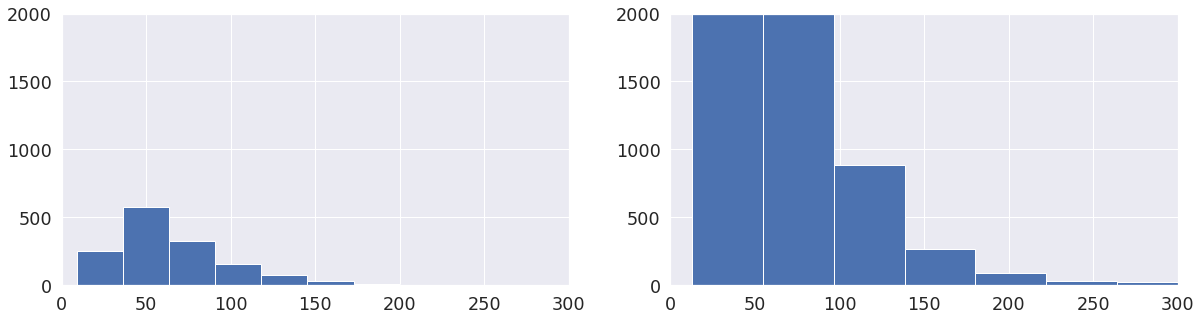

In [23]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
df_merged.query('correct==False')['blur'].hist()
plt.xlim(0,300);plt.ylim(0,2000)
plt.subplot(1,2,2)
df_merged.query('correct==True')['blur'].hist()
plt.xlim(0,300);plt.ylim(0,2000);

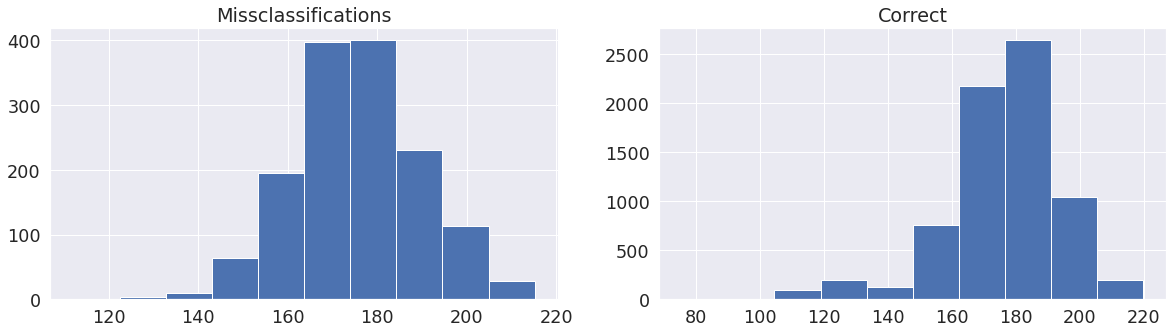

In [24]:
feature = "G"
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
df_merged.query('correct==False')[feature].hist();plt.title('Missclassifications');
# plt.xlim(0,300);plt.ylim(0,2000)
plt.subplot(1,2,2)
df_merged.query('correct==True')[feature].hist();plt.title('Correct');
# plt.xlim(0,300);plt.ylim(0,2000);

100%|██████████| 20/20 [00:00<00:00, 82.84it/s]


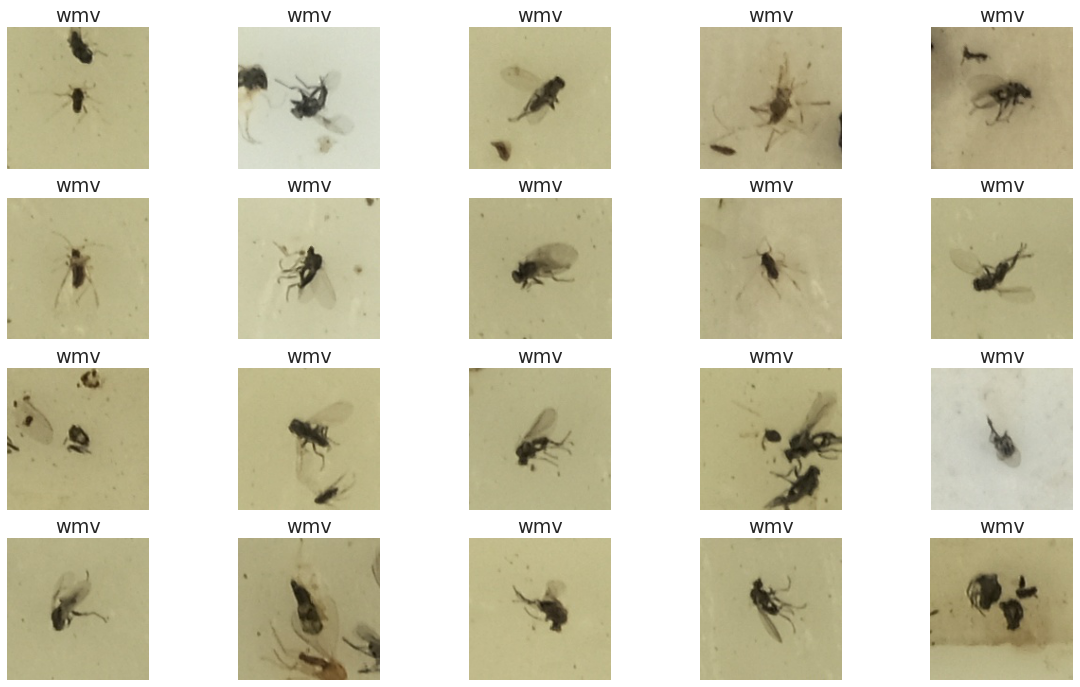

In [25]:
dfs.plot_samples(df_merged.query('actual_class==\'wmv\' & pred_class!=\'wmv\''))

100%|██████████| 20/20 [00:00<00:00, 58.46it/s]


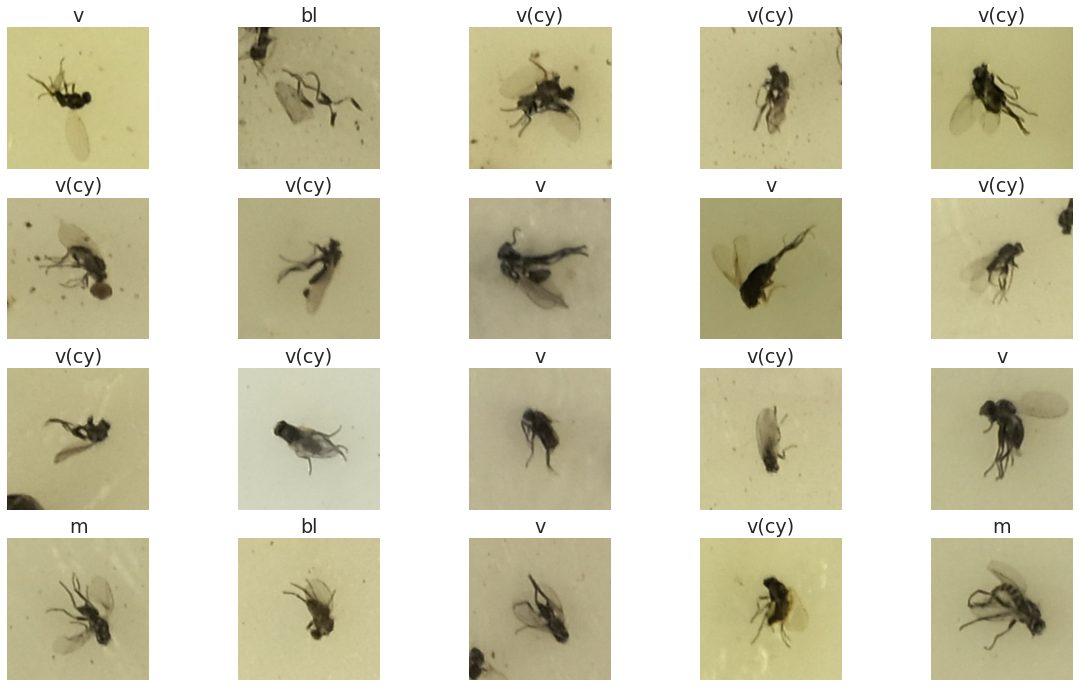

In [26]:
dfs.plot_samples(df_merged.query('actual_class!=\'wmv\' & pred_class==\'wmv\''))

100%|██████████| 20/20 [00:00<00:00, 79.83it/s]


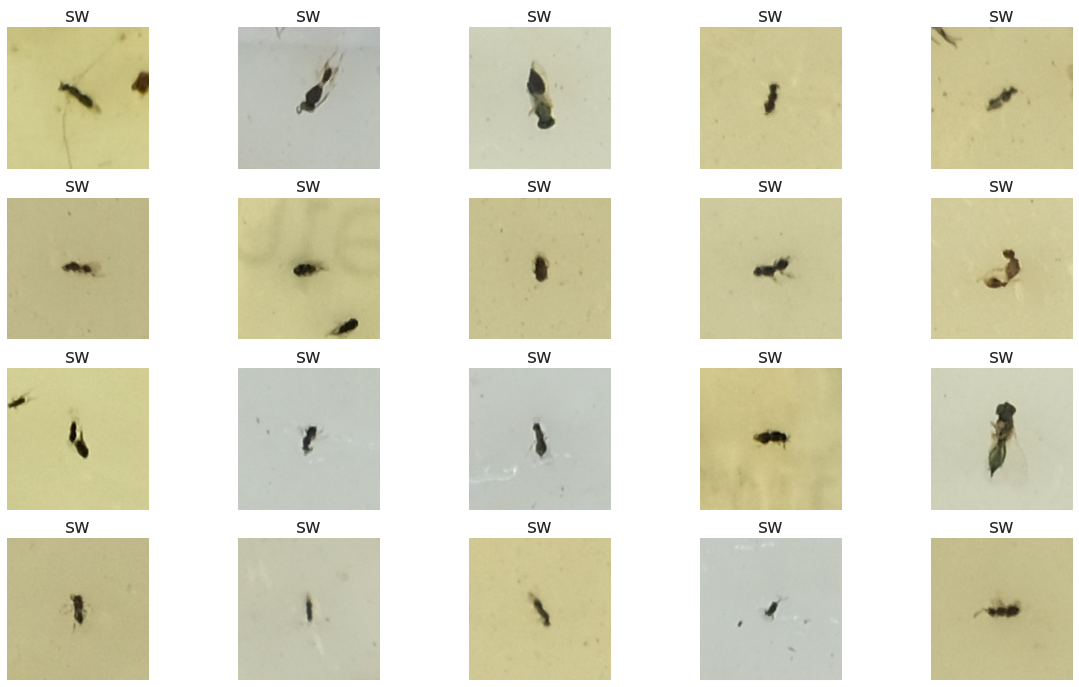

In [27]:
dfs.plot_samples(df_merged.query('nb_contours<=2 & actual_class==\'sw\'' ))

In [28]:
sub = df_merged.query('nb_contours==0 & actual_class==\'sw\'' )

In [29]:
Image.open(sub.filename.iloc[3])

IndexError: single positional indexer is out-of-bounds